In [6]:
import os
import sys
import itertools
import random
import glob
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import torch
from torch.utils.data import Dataset, DataLoader 
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from icecream import ic

from PIL import Image
from classes.NIH_dataset_class import NIH_dataset
from classes.Metrics_class import Metrics

# Loading the data

In [ ]:
# Getting the directories for data
DATA_DIR = os.path.join(os.getcwd(), 'dataset')
IMAGE_DIR = [os.path.join(os.path.join(os.getcwd(), 'dataset'), f'images_{str(i).zfill(3)}', 'images') for i in range(1, 13)]
LABELS_CSV = os.path.join(DATA_DIR, 'Data_Entry_2017.csv')
BBOX_CSV = os.path.join(DATA_DIR, 'BBox_List_2017.csv')

labels = pd.read_csv(LABELS_CSV)
bbox = pd.read_csv(BBOX_CSV)

# Splitting the labels into multiple rows
labels_expanded = labels.copy()
labels_expanded['Finding Label'] = labels_expanded['Finding Labels'].str.split('|')

# Making a unique Id column for each image
labels_expanded['Id'] = list(zip(labels_expanded['Patient ID'], labels_expanded['Follow-up #']))
labels_expanded = labels_expanded.explode('Finding Label')
data = labels_expanded[['Id','Image Index', 'Finding Label', 'Patient Age', 'Patient Gender', 'View Position']].copy()

# Removing the entries with "No Finding" label
data = data[data['Finding Label'] != 'No Finding']

# Adding the disease code to the data
disease_to_number = {'Cardiomegaly': 0,
                    'Emphysema': 1,
                    'Effusion': 2,
                    'Hernia': 3,
                    'Infiltration': 4,
                    'Mass': 5,
                    'Nodule': 6,
                    'Atelectasis': 7,
                    'Pneumothorax': 8,
                    'Pleural_Thickening': 9,
                    'Pneumonia': 10,
                    'Fibrosis': 11,
                    'Edema': 12,
                    'Consolidation': 13}

data.loc[:, 'Disease Code'] = data['Finding Label'].map(disease_to_number)
data['Id'] = data.apply(lambda row: (row['Id'][0], row['Id'][1], row['Disease Code']), axis=1)
data = data[['Id', 'Image Index', 'Finding Label', 'Patient Age', 'Patient Gender', 'View Position']]

# Resetting the index
data.reset_index(drop=True, inplace=True)
disease_to_number

{'Cardiomegaly': 0,
 'Emphysema': 1,
 'Effusion': 2,
 'Hernia': 3,
 'Infiltration': 4,
 'Mass': 5,
 'Nodule': 6,
 'Atelectasis': 7,
 'Pneumothorax': 8,
 'Pleural_Thickening': 9,
 'Pneumonia': 10,
 'Fibrosis': 11,
 'Edema': 12,
 'Consolidation': 13}

# Printing an Image

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

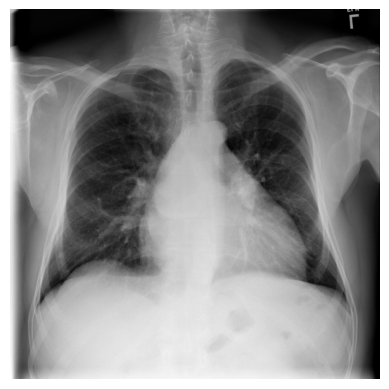

In [3]:
image_paths = glob.glob(os.path.join(DATA_DIR, 'images_*', 'images', '*.png'))
image_dict = {os.path.basename(path): path for path in image_paths}

sample_images = data['Image Index'].unique()
img_name = np.random.choice(sample_images, size=1, replace=False)[0]
img_path = image_dict.get(img_name)
img = Image.open(img_path)
data1 = data[data['Image Index'] == img_name]

img = torchvision.io.decode_image(image_dict.get("00000001_000.png"))
# print(img.shape)
img = img.permute(1,2,0)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
# plt.show()

# Loading the parameters and dataloaders

In [ ]:
# Getting the image paths
image_paths = glob.glob(os.path.join(DATA_DIR, 'images_*', 'images', '*.png'))

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 50
learning_rate = 0.0005
batch_size = 140
test_split_size = 0.2
train_size = 0.8
# num_of_workers = 16

# Defining the model, loss function and optimizer
weights = models.ResNet50_Weights.DEFAULT # Pretrained weights
model = models.resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 15) # Change the output layer to 15 classes

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model) # Use multiple GPUs if available
model = model.to(device) # Move the model to the device

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Try different transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(degrees=30),
    # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
    
])

#splitting the dataset
train_df, test_df = train_test_split(data,test_size=test_split_size,train_size=train_size)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_dataset = NIH_dataset(df=train_df, image_directories=image_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = NIH_dataset(df=test_df, image_directories=image_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Training the model

In [ ]:
def train(epochs: int, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer) -> tuple[torch.nn.Module, Metrics]:
    metrics = Metrics()
    for epoch in tqdm.tqdm(range(epochs), desc="Epochs"):
        for inputs, labels in tqdm.tqdm(dataloader):
            # Move input and label tensors to the device
            inputs = inputs.to(device)
            labels = torch.tensor([disease_to_number[label] for label in labels]).to(device)
            
            # Zero out the optimizer
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            max_logits, out_lab = torch.max(outputs, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)
            

            # Metrics
            metrics.compute(labels.cpu(), out_lab.cpu(), loss.cpu())

            # Backward pass
            loss.backward()
            optimizer.step()

    return model, metrics

resnet_trained, metrics = train(epochs, model, train_loader, criterion, optimizer)
metrics.process_by_groups(group_size=len(train_loader))
print(metrics)
metrics.plot(save=True)

# Save the model and dataloaders

In [ ]:
# Save the model
torch.save(resnet_trained, f"{model.__class__.__name__}_{epochs} epochs_{learning_rate} lr_{batch_size} batch_size.pth")

train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')

# Clearing cache and running garbage collector

In [ ]:
# Empty GPU
import gc

try:
    del model
except:
    pass
try:
    del resnet_trained
except:
    pass
try:
    del metrics
except:
    pass

gc.collect()
torch.cuda.empty_cache()
